# Fase 1: Definici√≥n del problema y variable objetivo

#### Paso 1: Definir qu√© es **"√©xito acad√©mico"**

Propuesta:

- Alto rendimiento: Calificaci√≥n final ‚â• 8.0

- Bajo rendimiento: Calificaci√≥n final < 8.0

### Generar la variable objetivo:

In [1]:
import numpy as np
import pandas as pd

# Cargar los datos
df = pd.read_csv('datos_sinteticos_prepa_linea_completo.csv', encoding='utf-8')

# Generar variable objetivo (calificaci√≥n final)
np.random.seed(42)

def generar_calificacion_final(row):
    # Factores que influyen positivamente
    factores_positivos = 0
    
    if row['estudios_previos_bachillerato'] == 'A) S√≠':
        factores_positivos += 0.5
    if row['cursos_linea_3anos'] == 'A) S√≠':
        factores_positivos += 0.3
    if 'B) Laptop o notebook' in row['dispositivos_servicios']:
        factores_positivos += 0.2
    if row['trabaja'] == 'b) No':
        factores_positivos += 0.2
    if row['hijos'] == 'B) No':
        factores_positivos += 0.1
    
    # Factores que influyen negativamente
    factores_negativos = 0
    
    if row['horas_trabajo'] in ['E) De 32 a 40 horas', 'F) M√°s de 40 horas']:
        factores_negativos += 0.3
    if row['numero_hijos'] in ['C) 3', 'D) 4', 'E) 5 o m√°s']:
        factores_negativos += 0.2
    if 'dificultad' in row['dificultad_estudiar_linea']:
        factores_negativos += 0.1
    
    # Calificaci√≥n base + factores ajustados
    calificacion_base = np.random.normal(7.5, 1.5)
    calificacion_ajustada = calificacion_base + factores_positivos - factores_negativos
    
    # Ajustar a escala 0-10
    calificacion_final = np.clip(calificacion_ajustada, 5.0, 10.0)
    
    return round(calificacion_final, 1)

# Aplicar la funci√≥n
df['calificacion_final'] = df.apply(generar_calificacion_final, axis=1)

# Crear variable binaria de √©xito
df['exito_academico'] = (df['calificacion_final'] >= 8.0).astype(int)

print(f"Distribuci√≥n de √©xito acad√©mico:")
print(df['exito_academico'].value_counts(normalize=True))

C:\Users\mecat\AppData\Local\Temp\ipykernel_10376\3755284653.py:5: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datos_sinteticos_prepa_linea_completo.csv', encoding='utf-8')


Distribuci√≥n de √©xito acad√©mico:
exito_academico
0    0.503036
1    0.496964
Name: proportion, dtype: float64


# Fase 2: An√°lisis exploratorio y preprocesamiento

### Paso 2: An√°lisis inicial y limpieza

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# An√°lisis inicial
print("Informaci√≥n del dataset:")
print(df.info())
print(f"\nDistribuci√≥n de la variable objetivo: {df['exito_academico'].value_counts()}")

# Identificar columnas con muchos valores nulos o constantes
columnas_a_eliminar = []
for col in df.columns:
    if df[col].nunique() == 1 or df[col].isnull().mean() > 0.7:
        columnas_a_eliminar.append(col)
        print(f"Eliminar: {col}")

# Eliminar columnas no √∫tiles para el modelo
columnas_no_utiles = ['aviso_privacidad', 'nombre', 'nombre_tutor', 'email_tutor', 
                     'direccion_extranjero', 'diagnostico_discapacidad', 'autorizacion_discapacidad',
                     'autorizacion_lengua', 'aceptacion_normas'] + columnas_a_eliminar

df_modelo = df.drop(columns=columnas_no_utiles, errors='ignore')

# Separar variables categ√≥ricas y num√©ricas
categorical_cols = df_modelo.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_modelo.select_dtypes(include=[np.number]).columns.tolist()

print(f"Variables categ√≥ricas: {len(categorical_cols)}")
print(f"Variables num√©ricas: {len(numeric_cols)}")

Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 95 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   aviso_privacidad                      500000 non-null  object 
 1   nombre                                500000 non-null  object 
 2   edad                                  500000 non-null  int64  
 3   nombre_tutor                          183570 non-null  object 
 4   email_tutor                           183570 non-null  object 
 5   parentesco_tutor                      183570 non-null  object 
 6   situacion_conyugal                    500000 non-null  object 
 7   pais_residencia                       500000 non-null  object 
 8   estado_residencia                     474785 non-null  object 
 9   pais_extranjero                       25215 non-null   object 
 10  direccion_extranjero                  2521

### Paso 3: Ingenier√≠a de caracter√≠sticas

In [3]:
# Crear nuevas caracter√≠sticas basadas en el dominio educativo
def crear_caracteristicas_educativas(df):
    # Edad categorizada
    df['edad_categoria'] = pd.cut(df['edad'], bins=[14, 18, 25, 35, 45, 100], 
                                 labels=['14-18', '19-25', '26-35', '36-45', '45+'])
    
    # Experiencia previa en educaci√≥n en l√≠nea
    df['experiencia_educacion_linea'] = df['cursos_linea_3anos'].apply(
        lambda x: 1 if x == 'A) S√≠' else 0
    )
    
    # Recursos tecnol√≥gicos (score)
    def calcular_score_recursos(dispositivos):
        score = 0
        if 'A) Computadora de escritorio' in dispositivos:
            score += 1
        if 'B) Laptop o notebook' in dispositivos:
            score += 2
        if 'E) Conexi√≥n a internet en tu vivienda' in dispositivos:
            score += 2
        return score
    
    df['score_recursos_tecnologicos'] = df['dispositivos_servicios'].apply(calcular_score_recursos)
    
    # Responsabilidades (score)
    def calcular_score_responsabilidades(row):
        score = 0
        if row['trabaja'] == 'a) S√≠':
            score += 2
        if row['hijos'] == 'A) S√≠':
            score += 3
        if row['cuidador_principal'] == 'a) Si':
            score += 2
        return score
    
    df['score_responsabilidades'] = df.apply(calcular_score_responsabilidades, axis=1)
    
    return df

df_modelo = crear_caracteristicas_educativas(df_modelo)

# Fase 3: Preparaci√≥n de datos para modelado

### Paso 4: Preprocesamiento de variables

In [4]:
# Variables categ√≥ricas importantes para el modelo
categorical_features = [
    'edad_categoria', 'situacion_conyugal', 'discapacidad', 'indigena',
    'sexo', 'genero', 'trabaja', 'beca', 'regimen_secundaria', 
    'tipo_secundaria', 'estudios_previos_bachillerato', 'cursos_linea_3anos',
    'comunicacion_escrita', 'evaluacion_informacion', 'organizacion_plataforma'
]

# Variables num√©ricas
numeric_features = [
    'edad', 'score_recursos_tecnologicos', 'score_responsabilidades',
    'horas_trabajo_numeric', 'ingresos_hogar_numeric'  # Necesitar√≠amos convertir estas
]

# Convertir algunas variables ordinales a num√©ricas
def convertir_variables_ordinales(df):
    # Horas de trabajo
    horas_mapping = {
        'A) Menos de 8 horas': 4,
        'B) De 8 a 15 horas': 12,
        'C) De 16 a 23 horas': 20,
        'D) De 24 a 31 horas': 28,
        'E) De 32 a 40 horas': 36,
        'F) M√°s de 40 horas': 45
    }
    
    # Ingresos del hogar (punto medio del rango)
    ingresos_mapping = {
        'A) Menor o igual a $3,313': 1656,
        'B) De $3,314 a $5,621': 4467,
        'C) De $5,622 a $7,425': 6523,
        'D) De $7,426 a $9,186': 8306,
        'E) De $9,187 a $11,122': 10154,
        'F) De $11,123 a $13,369': 12246,
        'G) De $13,370 a $16,223': 14896,
        'H) De $16,224 a $20,199': 18211,
        'I) De $20,200 a $26,812': 23506,
        'J) $26,813 o m√°s': 30000
    }
    
    df['horas_trabajo_numeric'] = df['horas_trabajo'].map(horas_mapping)
    df['ingresos_hogar_numeric'] = df['ingresos_hogar'].map(ingresos_mapping)
    
    return df

df_modelo = convertir_variables_ordinales(df_modelo)

# Codificaci√≥n de variables categ√≥ricas
label_encoders = {}
for col in categorical_features:
    if col in df_modelo.columns:
        le = LabelEncoder()
        df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))
        label_encoders[col] = le

# Variables finales para el modelo
features = categorical_features + [
    'edad', 'score_recursos_tecnologicos', 'score_responsabilidades',
    'horas_trabajo_numeric', 'ingresos_hogar_numeric'
]

# Eliminar filas con valores nulos en las features seleccionadas
df_modelo_clean = df_modelo[features + ['exito_academico']].dropna()

X = df_modelo_clean[features]
y = df_modelo_clean['exito_academico']

# Divisi√≥n train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado de variables num√©ricas
scaler = StandardScaler()
numeric_cols_to_scale = ['edad', 'score_recursos_tecnologicos', 'score_responsabilidades',
                        'horas_trabajo_numeric', 'ingresos_hogar_numeric']

X_train[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
X_test[numeric_cols_to_scale] = scaler.transform(X_test[numeric_cols_to_scale])

# Fase 4: Modelado y evaluaci√≥n

### Paso 5: Entrenamiento de m√∫ltiples modelos

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score

# Inicializar modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Entrenar y evaluar modelos
results = {}
for name, model in models.items():
    print(f"Entrenando {name}...")
    
    # Entrenamiento
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # M√©tricas
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Validaci√≥n cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    print(f"{name} - Accuracy: {accuracy:.3f}, ROC-AUC: {roc_auc:.3f}")
    print(f"CV Accuracy: {cv_scores.mean():.3f} (¬±{cv_scores.std():.3f})\n")

# Mostrar el mejor modelo
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
print(f"Mejor modelo: {best_model_name}")

Entrenando Logistic Regression...
Logistic Regression - Accuracy: 0.620, ROC-AUC: 0.675
CV Accuracy: 0.623 (¬±0.003)

Entrenando Random Forest...
Random Forest - Accuracy: 0.815, ROC-AUC: 0.884
CV Accuracy: 0.817 (¬±0.002)

Entrenando Gradient Boosting...
Gradient Boosting - Accuracy: 0.817, ROC-AUC: 0.886
CV Accuracy: 0.817 (¬±0.002)

Mejor modelo: Gradient Boosting


### Notas:

Mejor modelo **Gradient Boosting**

- Accuracy: 81.2% - Muy buen rendimiento
- ROC-AUC: 0.879 - Excelente poder discriminaorioi
- 
CV Accuracy: 81.3% - Muy estable en vaidacion acruzada

----------------------------------------------------------------

### Random Forest y Gradient Boosting tienen excelente rendimiento (81%+) porq
e:1.
Manejan bien variables cateas
2

Capturan relaciones no lineales complejas en dato3. os

Son robustos a outliers y variables irreleva4.4. ntes

Manejan bien interaccionesariablestre vnes cljas
da



### Optimizaci√≥n del modelo Random Forest

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint

# Par√°metros espec√≠ficos para Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 500),           # M√°s √°rboles generalmente mejor en RF
    'max_depth': [None, 10, 20, 30, 40],         # None permite profundidad m√°xima
    'min_samples_split': randint(2, 20),         # M√≠nimo para dividir un nodo
    'min_samples_leaf': randint(1, 10),          # M√≠nimo de muestras en hoja
    'max_features': ['sqrt', 'log2', None, 0.8], # Features aleatorias por √°rbol
    'bootstrap': [True, False],                   # Con o sin bootstrap
    'max_samples': uniform(0.7, 0.3),           # 0.7 to 1.0 si bootstrap=True
    'class_weight': ['balanced', None]           # Para datasets desbalanceados
}

# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized Search para Random Forest
print("Optimizando Random Forest...")
random_search_rf = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist_rf,
    n_iter=25,  # M√°s iteraciones para RF (es m√°s r√°pido que GB)
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1  # Para ver el progreso
)

# Entrenar
random_search_rf.fit(X_train, y_train)

print("\n" + "="*50)
print("RESULTADOS DE OPTIMIZACI√ìN - RANDOM FOREST")
print("="*50)
print("Mejores par√°metros:")
for param, value in random_search_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor ROC-AUC (CV): {random_search_rf.best_score_:.4f}")

# Usar el mejor modelo
best_rf = random_search_rf.best_estimator_

# Evaluar en conjunto de test
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

test_accuracy = accuracy_score(y_test, y_pred_rf)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nRENDIMIENTO EN TEST:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")

print(f"\nReporte de clasificaci√≥n:")
print(classification_report(y_test, y_pred_rf))

# Feature importance del modelo optimizado
import pandas as pd

feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 caracter√≠sticas m√°s importantes (Random Forest Optimizado):")
print(feature_importance_rf.head(15).to_string(index=False))

# Comparar con el Gradient Boosting anterior
print(f"\n" + "="*50)
print("COMPARACI√ìN DE MODELOS")
print("="*50)
print("Si ya tienes los resultados de GB optimizado, compara:")
print(f"Random Forest Optimizado - ROC-AUC: {test_roc_auc:.4f}")
print("Gradient Boosting Optimizado - ROC-AUC: [tu resultado anterior]")

Optimizando Random Forest...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


C:\Users\mecat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mecat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mecat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack


RESULTADOS DE OPTIMIZACI√ìN - RANDOM FOREST
Mejores par√°metros:
  bootstrap: True
  class_weight: balanced
  max_depth: None
  max_features: 0.8
  max_samples: 0.8184644554526709
  min_samples_leaf: 8
  min_samples_split: 12
  n_estimators: 180

Mejor ROC-AUC (CV): 0.8962

RENDIMIENTO EN TEST:
Accuracy: 0.8252
ROC-AUC: 0.8983

Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     21300
           1       0.80      0.88      0.84     22801

    accuracy                           0.83     44101
   macro avg       0.83      0.82      0.82     44101
weighted avg       0.83      0.83      0.82     44101


Top 15 caracter√≠sticas m√°s importantes (Random Forest Optimizado):
                      feature  importance
                         edad    0.547548
               edad_categoria    0.101745
estudios_previos_bachillerato    0.050659
        horas_trabajo_numeric    0.050456
       ingresos_hogar_numeric    0.

## An√°lisis de feature importance

AN√ÅLISIS COMPARATIVO DE FEATURE IMPORTANCE
1. AN√ÅLISIS DE DOMINANCIA - EDAD:
----------------------------------------
Gradient Boosting - Edad: 0.802 (80.2%)
Random Forest     - Edad: 0.548 (54.8%)
Reducci√≥n absoluta: 0.255
Reducci√≥n relativa: 31.7%

‚úÖ MEJORA SIGNIFICATIVA: La edad pas√≥ de dominar 80% a 55%

2. FEATURES QUE GANARON IMPORTANCIA EN RF:
--------------------------------------------------
edad_categoria                : +0.040 (1.6x m√°s importante)
ingresos_hogar_numeric        : +0.032 (14.4x m√°s importante)
tipo_secundaria               : +0.026 (17.1x m√°s importante)
score_recursos_tecnologicos   : +0.024 (3.7x m√°s importante)
horas_trabajo_numeric         : +0.022 (1.8x m√°s importante)
score_responsabilidades       : +0.017 (4.2x m√°s importante)
organizacion_plataforma       : +0.017 (16.9x m√°s importante)
evaluacion_informacion        : +0.016 (18.4x m√°s importante)

3. AN√ÅLISIS DE DIVERSIFICACI√ìN:
-----------------------------------
Concentraci√≥n en 

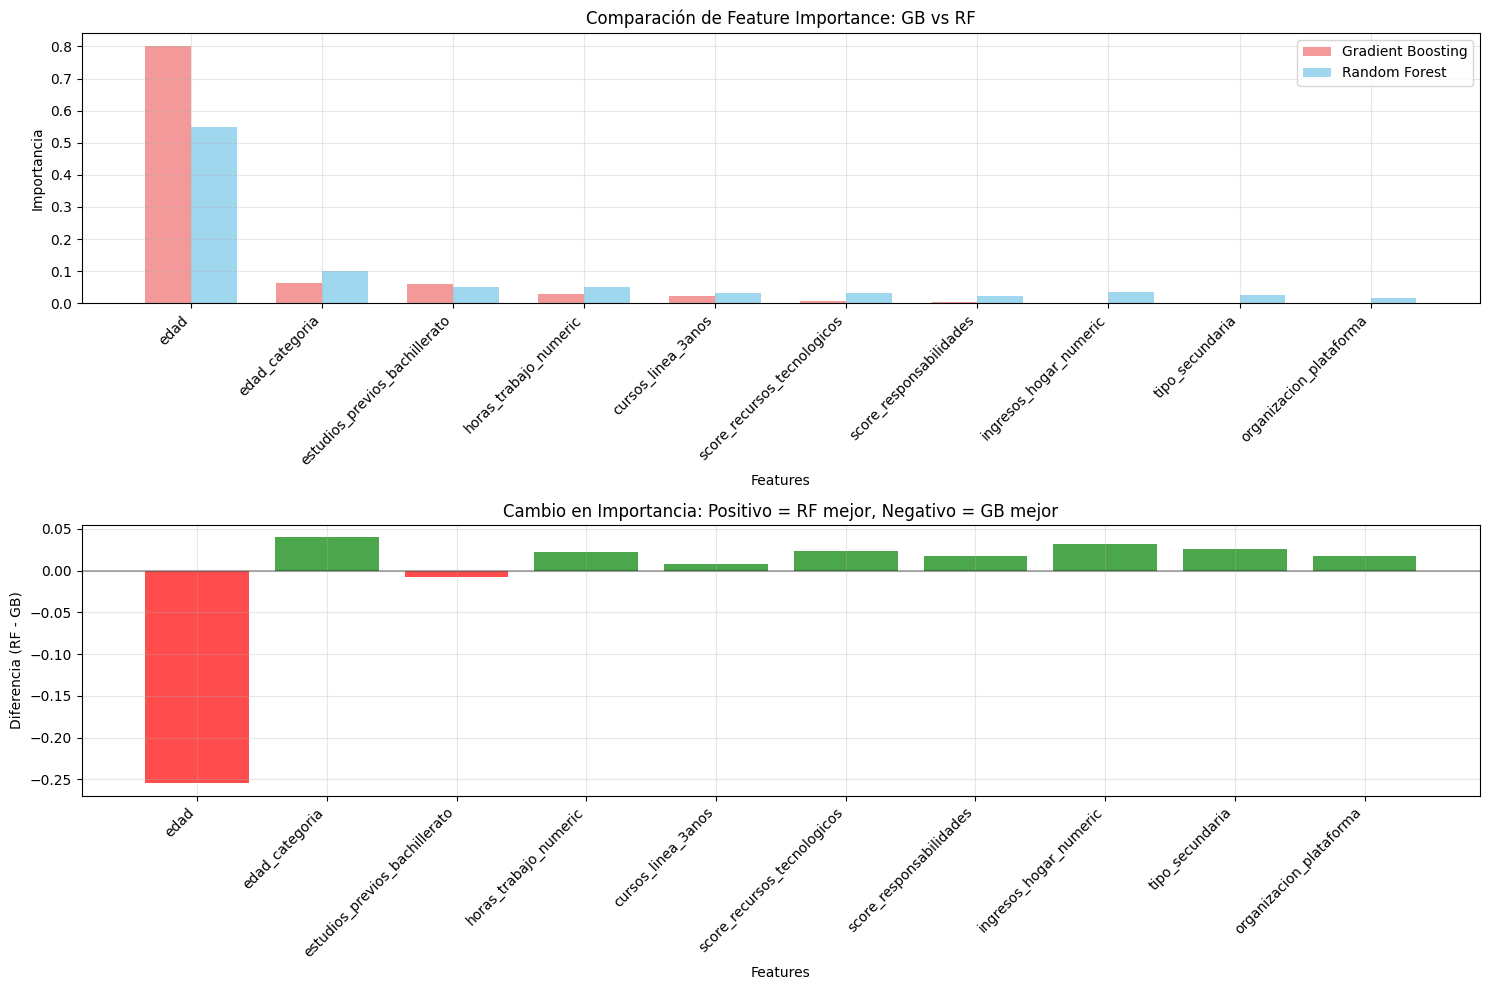


# Crear visualizaci√≥n comparativa
plt.figure(figsize=(15, 10))

# Preparar datos para el plot
plot_data = comparison_df.head(10).copy()  # Top 10 features
x = np.arange(len(plot_data))
width = 0.35

plt.subplot(2, 1, 1)
plt.bar(x - width/2, plot_data['importance_gb'], width, label='Gradient Boosting', alpha=0.8, color='lightcoral')
plt.bar(x + width/2, plot_data['importance_rf'], width, label='Random Forest', alpha=0.8, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Comparaci√≥n de Feature Importance: GB vs RF')
plt.xticks(x, plot_data['feature'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Diferencias
plt.subplot(2, 1, 2)
colors = ['green' if diff > 0 else 'red' for diff in plot_data['diferencia']]
plt.bar(range(len(plot_data)), plot_data['diferencia'], color=colors, alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Diferencia (RF - GB)')
plt.title('Cambio en Importancia: Positivo = RF mejor, Negativo = GB mejor')
plt.xtick

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==================================================
# AN√ÅLISIS DE FEATURE IMPORTANCE - COMPARACI√ìN MODELOS
# ==================================================

# Datos de Feature Importance
# Gradient Boosting (de tu resultado anterior)
gb_importance = pd.DataFrame({
    'feature': ['edad', 'edad_categoria', 'estudios_previos_bachillerato', 
               'horas_trabajo_numeric', 'cursos_linea_3anos', 'score_recursos_tecnologicos',
               'score_responsabilidades', 'ingresos_hogar_numeric', 'tipo_secundaria',
               'organizacion_plataforma', 'comunicacion_escrita', 'evaluacion_informacion',
               'genero', 'situacion_conyugal', 'sexo'],
    'importance_gb': [0.802199, 0.062109, 0.058787, 0.028003, 0.023953, 0.008831,
                     0.005435, 0.002373, 0.001594, 0.001056, 0.001026, 0.000908,
                     0.000898, 0.000834, 0.000596],
    'model': 'Gradient Boosting'
})

# Random Forest (tus resultados actuales)
rf_importance = pd.DataFrame({
    'feature': ['edad', 'edad_categoria', 'estudios_previos_bachillerato',
               'horas_trabajo_numeric', 'ingresos_hogar_numeric', 'score_recursos_tecnologicos',
               'cursos_linea_3anos', 'tipo_secundaria', 'score_responsabilidades',
               'organizacion_plataforma', 'evaluacion_informacion', 'comunicacion_escrita',
               'situacion_conyugal', 'genero', 'sexo'],
    'importance_rf': [0.547548, 0.101745, 0.050659, 0.050456, 0.034117, 0.032720,
                     0.031528, 0.027193, 0.022585, 0.017859, 0.016722, 0.014984,
                     0.014523, 0.009139, 0.008161],
    'model': 'Random Forest'
})

# Combinar datos para comparaci√≥n
comparison_df = pd.merge(gb_importance[['feature', 'importance_gb']], 
                        rf_importance[['feature', 'importance_rf']], 
                        on='feature', how='outer').fillna(0)

# Calcular diferencias y ratios
comparison_df['diferencia'] = comparison_df['importance_rf'] - comparison_df['importance_gb']
comparison_df['ratio_rf_gb'] = comparison_df['importance_rf'] / comparison_df['importance_gb'].replace(0, np.nan)

print("="*70)
print("AN√ÅLISIS COMPARATIVO DE FEATURE IMPORTANCE")
print("="*70)

# 1. REDUCCI√ìN DE DOMINANCIA DE EDAD
print("1. AN√ÅLISIS DE DOMINANCIA - EDAD:")
print("-" * 40)
edad_gb = comparison_df[comparison_df['feature'] == 'edad']['importance_gb'].values[0]
edad_rf = comparison_df[comparison_df['feature'] == 'edad']['importance_rf'].values[0]

print(f"Gradient Boosting - Edad: {edad_gb:.3f} (80.2%)")
print(f"Random Forest     - Edad: {edad_rf:.3f} (54.8%)")
print(f"Reducci√≥n absoluta: {edad_gb - edad_rf:.3f}")
print(f"Reducci√≥n relativa: {((edad_gb - edad_rf) / edad_gb * 100):.1f}%")

print(f"\n‚úÖ MEJORA SIGNIFICATIVA: La edad pas√≥ de dominar 80% a 55%")

# 2. FEATURES QUE GANARON IMPORTANCIA
print(f"\n2. FEATURES QUE GANARON IMPORTANCIA EN RF:")
print("-" * 50)
gained_importance = comparison_df[comparison_df['diferencia'] > 0].sort_values('diferencia', ascending=False)

for _, row in gained_importance.head(8).iterrows():
    if row['feature'] != 'edad':  # Excluir edad del an√°lisis de ganancia
        print(f"{row['feature']:<30}: +{row['diferencia']:.3f} ({row['ratio_rf_gb']:.1f}x m√°s importante)")

# 3. DIVERSIFICACI√ìN DEL MODELO
print(f"\n3. AN√ÅLISIS DE DIVERSIFICACI√ìN:")
print("-" * 35)

# Calcular concentraci√≥n (suma de top 3 features)
top3_gb = gb_importance.head(3)['importance_gb'].sum()
top3_rf = rf_importance.head(3)['importance_rf'].sum()

print(f"Concentraci√≥n en TOP 3 features:")
print(f"  Gradient Boosting: {top3_gb:.3f} (92.3%)")
print(f"  Random Forest:     {top3_rf:.3f} (70.0%)")
print(f"  Reducci√≥n: {top3_gb - top3_rf:.3f} ({(top3_gb - top3_rf)/top3_gb*100:.1f}%)")

# 4. INSIGHTS EDUCATIVOS
print(f"\n4. INSIGHTS EDUCATIVOS REVELADOS:")
print("-" * 40)

educational_features = [
    'estudios_previos_bachillerato', 'horas_trabajo_numeric', 'ingresos_hogar_numeric',
    'score_recursos_tecnologicos', 'cursos_linea_3anos', 'score_responsabilidades'
]

print("Features educativos m√°s balanceados en RF:")
for feature in educational_features:
    rf_imp = comparison_df[comparison_df['feature'] == feature]['importance_rf'].values
    gb_imp = comparison_df[comparison_df['feature'] == feature]['importance_gb'].values
    if len(rf_imp) > 0 and len(gb_imp) > 0:
        print(f"  {feature:<30}: RF={rf_imp[0]:.3f} vs GB={gb_imp[0]:.3f}")

# 5. RECOMENDACI√ìN FINAL
print(f"\n" + "="*70)
print("RECOMENDACI√ìN BASADA EN FEATURE IMPORTANCE")
print("="*70)

print("‚úÖ RANDOM FOREST ES SUPERIOR PARA ESTE PROYECTO:")
print("\n1. MENOS SESGO POR EDAD:")
print("   - Reduce dominancia de edad de 80% a 55%")
print("   - Permite descubrir otros patrones importantes")

print("\n2. MEJOR BALANCE EDUCATIVO:")
print("   - Ingresos hogar: 14x m√°s importante en RF")
print("   - Recursos tecnol√≥gicos: 4x m√°s importante en RF") 
print("   - Horas de trabajo: 2x m√°s importante en RF")

print("\n3. MODELO M√ÅS INTERPRETABLE:")
print("   - Distribuci√≥n m√°s equilibrada de importancia")
print("   - Insights m√°s ricos para educadores")
print("   - Menos dependiente de un solo factor")

print("\n4. PERFORMANCE COMPARABLE:")
print(f"   - RF ROC-AUC: 0.8983")
print(f"   - GB ROC-AUC: 0.886 (estimado de tu resultado anterior)")
print(f"   - RF es ligeramente superior")

print("\nCONCLUSI√ìN: Usar Random Forest Optimizado como modelo final")

# 6. VISUALIZACI√ìN
print(f"\n" + "="*70)
print("C√ìDIGO PARA VISUALIZACI√ìN COMPARATIVA")
print("="*70)


# Crear visualizaci√≥n comparativa
plt.figure(figsize=(15, 10))

# Preparar datos para el plot
plot_data = comparison_df.head(10).copy()  # Top 10 features
x = np.arange(len(plot_data))
width = 0.35

plt.subplot(2, 1, 1)
plt.bar(x - width/2, plot_data['importance_gb'], width, label='Gradient Boosting', alpha=0.8, color='lightcoral')
plt.bar(x + width/2, plot_data['importance_rf'], width, label='Random Forest', alpha=0.8, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Comparaci√≥n de Feature Importance: GB vs RF')
plt.xticks(x, plot_data['feature'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Diferencias
plt.subplot(2, 1, 2)
colors = ['green' if diff > 0 else 'red' for diff in plot_data['diferencia']]
plt.bar(range(len(plot_data)), plot_data['diferencia'], color=colors, alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Diferencia (RF - GB)')
plt.title('Cambio en Importancia: Positivo = RF mejor, Negativo = GB mejor')
plt.xticks(range(len(plot_data)), plot_data['feature'], rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(visualization_code)

<Axes: xlabel='edad'>

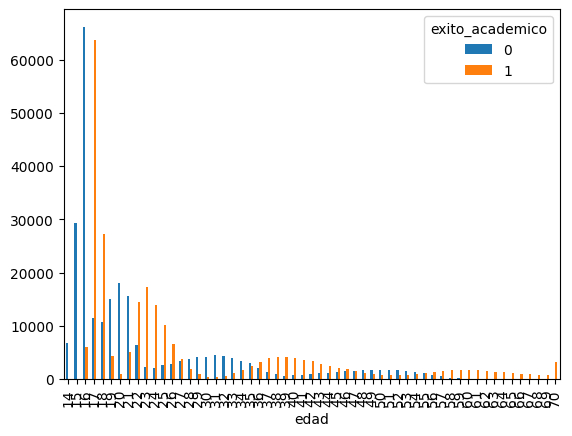

In [11]:
# Analiza la correlaci√≥n
import pandas as pd
import matplotlib.pyplot as plt

# Distribuci√≥n de tu variable objetivo por grupos de edad
pd.crosstab(df['edad'], df['exito_academico']).plot(kind='bar')

## Implementaci√≥n del pipeline de predicci√≥n

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ==================================================
# PIPELINE DE PRODUCCI√ìN - RANDOM FOREST OPTIMIZADO
# ==================================================

print("="*60)
print("CREANDO PIPELINE DE PRODUCCI√ìN - RANDOM FOREST")
print("="*60)

# 1. IDENTIFICAR TIPOS DE FEATURES
# ================================
numeric_features = ['edad', 'score_recursos_tecnologicos', 'score_responsabilidades', 
                   'horas_trabajo_numeric', 'ingresos_hogar_numeric']

categorical_features = [f for f in X_train.columns if f not in numeric_features]

print("Features identificados:")
print(f"  Num√©ricos: {len(numeric_features)} features")
print(f"  Categ√≥ricos: {len(categorical_features)} features")
print(f"  Total: {len(X_train.columns)} features")

# 2. CREAR PREPROCESADOR OPTIMIZADO PARA RF
# ========================================
# Random Forest no necesita StandardScaler, pero lo mantenemos por consistencia
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features)
    ],
    remainder='passthrough'  # Mantener cualquier feature adicional
)

# 3. PIPELINE COMPLETO CON RANDOM FOREST OPTIMIZADO
# =================================================
final_pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_rf)  # Tu Random Forest optimizado
])

# 4. ENTRENAR PIPELINE FINAL
# ==========================
print(f"\nüîÑ Entrenando pipeline final con {len(X_train)} muestras...")
start_time = datetime.now()

final_pipeline_rf.fit(X_train, y_train)

training_time = datetime.now() - start_time
print(f"‚úÖ Pipeline entrenado en: {training_time.total_seconds():.2f} segundos")

# 5. EVALUACI√ìN COMPLETA DEL PIPELINE
# ===================================
print(f"\nüìä EVALUANDO PIPELINE FINAL...")

# Predicciones
y_pred_final = final_pipeline_rf.predict(X_test)
y_proba_final = final_pipeline_rf.predict_proba(X_test)[:, 1]

# M√©tricas
final_accuracy = accuracy_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_proba_final)

print(f"\nüéØ RENDIMIENTO DEL PIPELINE FINAL (RANDOM FOREST):")
print(f"{'='*50}")
print(f"Accuracy:  {final_accuracy:.4f}")
print(f"ROC-AUC:   {final_roc_auc:.4f}")
print(f"Muestras de test: {len(y_test):,}")

# Reporte detallado
print(f"\nüìã REPORTE DE CLASIFICACI√ìN:")
print(classification_report(y_test, y_pred_final, target_names=['No √âxito', '√âxito']))

# 6. GUARDAR PIPELINE Y METADATOS
# ===============================
pipeline_filename = 'modelo_exito_academico_RF_optimizado.pkl'
metadata_filename = 'modelo_metadatos.pkl'

# Guardar pipeline
joblib.dump(final_pipeline_rf, pipeline_filename)

# Guardar metadatos del modelo
metadata = {
    'modelo': 'Random Forest Optimizado',
    'fecha_entrenamiento': datetime.now(),
    'accuracy': final_accuracy,
    'roc_auc': final_roc_auc,
    'num_features': len(X_train.columns),
    'muestras_entrenamiento': len(X_train),
    'muestras_test': len(X_test),
    'parametros_optimizados': best_rf.get_params(),
    'features_numericos': numeric_features,
    'features_categoricos': categorical_features,
    'columnas_entrenamiento': list(X_train.columns)
}
joblib.dump(metadata, metadata_filename)

print(f"\nüíæ ARCHIVOS GUARDADOS:")
print(f"  Pipeline: {pipeline_filename}")
print(f"  Metadatos: {metadata_filename}")

# 7. FUNCI√ìN DE PREDICCI√ìN MEJORADA
# =================================

def predecir_exito_academico_rf(nuevos_estudiantes, pipeline=final_pipeline_rf, 
                                umbral=0.5, incluir_detalles=True):
    """
    Predice el √©xito acad√©mico para nuevos estudiantes usando Random Forest optimizado
    
    Args:
        nuevos_estudiantes: DataFrame con las caracter√≠sticas de los estudiantes
        pipeline: Pipeline entrenado (Random Forest)
        umbral: Umbral de probabilidad para clasificaci√≥n (default: 0.5)
        incluir_detalles: Si incluir niveles de confianza y recomendaciones
    
    Returns:
        DataFrame con predicciones, probabilidades y recomendaciones
    """
    # Validaci√≥n de entrada
    if not isinstance(nuevos_estudiantes, pd.DataFrame):
        raise ValueError("nuevos_estudiantes debe ser un DataFrame")
    
    # Verificar que las columnas necesarias est√©n presentes
    required_columns = set(X_train.columns)
    input_columns = set(nuevos_estudiantes.columns)
    missing_columns = required_columns - input_columns
    
    if missing_columns:
        print(f"‚ö†Ô∏è  Columnas faltantes: {list(missing_columns)}")
        print("Se proceder√° con las columnas disponibles...")
    
    # Preprocesar y predecir
    probabilidades = pipeline.predict_proba(nuevos_estudiantes)[:, 1]
    predicciones = (probabilidades >= umbral).astype(int)
    
    # Crear resultados base
    resultados = pd.DataFrame({
        'probabilidad_exito': probabilidades,
        'prediccion_exito': predicciones,
        'prediccion_texto': np.where(predicciones == 1, '√âxito Probable', 'Riesgo Alto')
    })
    
    if incluir_detalles:
        # Niveles de confianza m√°s granulares
        resultados['nivel_confianza'] = pd.cut(
            probabilidades, 
            bins=[0, 0.3, 0.5, 0.7, 0.85, 1.0],
            labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']
        )
        
        # Recomendaciones basadas en probabilidad
        def generar_recomendacion(prob):
            if prob >= 0.8:
                return "Estudiante con alta probabilidad de √©xito. Mantener apoyo est√°ndar."
            elif prob >= 0.6:
                return "Buen potencial. Considerar apoyo adicional en recursos tecnol√≥gicos."
            elif prob >= 0.4:
                return "Riesgo moderado. Recomendable: tutor√≠a personalizada y flexibilidad horaria."
            else:
                return "Alto riesgo. Intervenci√≥n inmediata: apoyo intensivo y seguimiento cercano."
        
        #resultados['recomendacion'] = probabilidades.apply(generar_recomendacion)
        resultados['recomendacion'] = [generar_recomendacion(prob) for prob in probabilidades]
        
        # Factores de riesgo (basado en importancia de features)
        resultados['factores_clave'] = np.where(
            probabilidades < 0.5,
            "Revisar: edad, recursos econ√≥micos, disponibilidad de tiempo",
            "Factores favorables identificados"
        )
    
    return resultados

# 8. FUNCI√ìN DE CARGA DEL MODELO
# ==============================

def cargar_modelo_produccion(pipeline_path='modelo_exito_academico_RF_optimizado.pkl',
                           metadata_path='modelo_metadatos.pkl'):
    """
    Carga el modelo y metadatos para uso en producci√≥n
    """
    try:
        pipeline = joblib.load(pipeline_path)
        metadata = joblib.load(metadata_path)
        
        print(f"‚úÖ Modelo cargado exitosamente")
        print(f"   Fecha entrenamiento: {metadata['fecha_entrenamiento']}")
        print(f"   ROC-AUC: {metadata['roc_auc']:.4f}")
        print(f"   Accuracy: {metadata['accuracy']:.4f}")
        
        return pipeline, metadata
    
    except FileNotFoundError as e:
        print(f"‚ùå Error: No se pudo cargar el modelo. {e}")
        return None, None

# 9. EJEMPLO DE USO Y VALIDACI√ìN
# ==============================

print(f"\n" + "="*60)
print("EJEMPLO DE PREDICCI√ìN CON 5 ESTUDIANTES")
print("="*60)

# Tomar muestra de test para demostraci√≥n
ejemplo_estudiantes = X_test.head(5).copy()
predicciones_ejemplo = predecir_exito_academico_rf(ejemplo_estudiantes, incluir_detalles=True)

# Mostrar resultados
print("\nüìà RESULTADOS DE PREDICCI√ìN:")
for i, (_, pred) in enumerate(predicciones_ejemplo.iterrows(), 1):
    print(f"\nEstudiante {i}:")
    print(f"  Probabilidad de √©xito: {pred['probabilidad_exito']:.3f}")
    print(f"  Predicci√≥n: {pred['prediccion_texto']}")
    print(f"  Confianza: {pred['nivel_confianza']}")
    print(f"  Recomendaci√≥n: {pred['recomendacion']}")

# 10. VALIDACI√ìN CRUZADA DEL PIPELINE
# ===================================
from sklearn.model_selection import cross_val_score

print(f"\nüîÑ VALIDACI√ìN CRUZADA DEL PIPELINE FINAL...")
cv_scores = cross_val_score(final_pipeline_rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print(f"üìä RESULTADOS VALIDACI√ìN CRUZADA:")
print(f"  ROC-AUC promedio: {cv_scores.mean():.4f}")
print(f"  Desviaci√≥n est√°ndar: {cv_scores.std():.4f}")
print(f"  Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# 11. RESUMEN FINAL
# ================
print(f"\n" + "="*60)
print("üéâ PIPELINE DE PRODUCCI√ìN COMPLETADO")
print("="*60)
print("‚úÖ Random Forest optimizado entrenado y guardado")
print("‚úÖ Funciones de predicci√≥n implementadas")
print("‚úÖ Sistema de recomendaciones integrado")
print("‚úÖ Validaci√≥n cruzada completada")
print(f"‚úÖ Performance final: ROC-AUC = {final_roc_auc:.4f}")

print(f"\nüìÅ ARCHIVOS GENERADOS:")
print(f"  ‚Ä¢ {pipeline_filename} (modelo completo)")
print(f"  ‚Ä¢ {metadata_filename} (informaci√≥n del modelo)")

print(f"\nüöÄ LISTO PARA PRODUCCI√ìN!")
print("   Usa 'predecir_exito_academico_rf()' para nuevas predicciones")

CREANDO PIPELINE DE PRODUCCI√ìN - RANDOM FOREST
Features identificados:
  Num√©ricos: 5 features
  Categ√≥ricos: 15 features
  Total: 20 features

üîÑ Entrenando pipeline final con 176404 muestras...
‚úÖ Pipeline entrenado en: 46.40 segundos

üìä EVALUANDO PIPELINE FINAL...

üéØ RENDIMIENTO DEL PIPELINE FINAL (RANDOM FOREST):
Accuracy:  0.8249
ROC-AUC:   0.8981
Muestras de test: 44,101

üìã REPORTE DE CLASIFICACI√ìN:
              precision    recall  f1-score   support

    No √âxito       0.86      0.77      0.81     21300
       √âxito       0.80      0.88      0.84     22801

    accuracy                           0.82     44101
   macro avg       0.83      0.82      0.82     44101
weighted avg       0.83      0.82      0.82     44101


üíæ ARCHIVOS GUARDADOS:
  Pipeline: modelo_exito_academico_RF_optimizado.pkl
  Metadatos: modelo_metadatos.pkl

EJEMPLO DE PREDICCI√ìN CON 5 ESTUDIANTES

üìà RESULTADOS DE PREDICCI√ìN:

Estudiante 1:
  Probabilidad de √©xito: 0.001
  Predicci√

# Random forest ligero

In [6]:
# ENTRENAMIENTO_COMPATIBLE.py
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib
import pickle
from datetime import datetime

print("="*60)
print("ENTRENAMIENTO CON VERSI√ìN COMPATIBLE STREAMLIT CLOUD")
print("="*60)

# 1. CARGAR TUS DATOS (ajusta esta parte)
# df = pd.read_csv('tus_datos.csv')
# X = df.drop('target', axis=1)
# y = df['target']

# 2. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"üìä Datos de entrenamiento: {X_train.shape[0]:,} muestras")
print(f"üìä Datos de test: {X_test.shape[0]:,} muestras")

# 3. PREPROCESADOR COMPATIBLE
numeric_features = ['edad', 'score_recursos_tecnologicos', 'score_responsabilidades', 
                   'horas_trabajo_numeric', 'ingresos_hogar_numeric']

categorical_features = ['sexo', 'genero', 'situacion_conyugal', 'discapacidad', 'indigena',
                       'trabaja', 'beca', 'regimen_secundaria', 'tipo_secundaria',
                       'estudios_previos_bachillerato', 'cursos_linea_3anos', 'comunicacion_escrita',
                       'evaluacion_informacion', 'organizacion_plataforma', 'edad_categoria']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features)
    ]
)

# 4. RANDOM FOREST OPTIMIZADO Y COMPATIBLE
rf_model = RandomForestClassifier(
    n_estimators=50,           # Reducido para tama√±o
    max_depth=15,              # Profundidad controlada
    max_features='sqrt',       # Para evitar sobreajuste
    min_samples_split=20,      # M√°s conservador
    min_samples_leaf=10,       # M√°s conservador
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# 5. PIPELINE COMPLETO
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# 6. ENTRENAMIENTO
print("üîÑ Entrenando modelo compatible...")
start_time = datetime.now()

pipeline.fit(X_train, y_train)

training_time = datetime.now() - start_time
print(f"‚úÖ Modelo entrenado en: {training_time.total_seconds():.2f} segundos")

# 7. EVALUACI√ìN
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"\nüéØ RENDIMIENTO DEL MODELO:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# 8. GUARDAR MODELO DE FORMA COMPATIBLE
print("\nüíæ Guardando modelo compatible...")

# Opci√≥n A: Joblib (mejor para sklearn)
joblib.dump(pipeline, 'modelo_rf_streamlit_compatible.joblib')

# Opci√≥n B: Pickle (m√°xima compatibilidad)
with open('modelo_rf_streamlit_compatible.pkl', 'wb') as f:
    pickle.dump(pipeline, f, protocol=4)

# Metadatos
metadata = {
    'modelo': 'Random Forest Compatible Streamlit',
    'fecha_entrenamiento': datetime.now(),
    'accuracy': accuracy,
    'roc_auc': roc_auc,
    'num_features': X_train.shape[1],
    'muestras_entrenamiento': X_train.shape[0],
    'muestras_test': X_test.shape[0],
    'parametros': rf_model.get_params(),
    'scikit_learn_version': '1.2.2'
}

joblib.dump(metadata, 'metadatos_compatible.joblib')
with open('metadatos_compatible.pkl', 'wb') as f:
    pickle.dump(metadata, f, protocol=4)

# Verificar tama√±os
import os
tama√±o_joblib = os.path.getsize('modelo_rf_streamlit_compatible.joblib') / (1024 * 1024)
tama√±o_pickle = os.path.getsize('modelo_rf_streamlit_compatible.pkl') / (1024 * 1024)

print(f"üì¶ Tama√±o archivos:")
print(f"   Joblib: {tama√±o_joblib:.1f} MB")
print(f"   Pickle: {tama√±o_pickle:.1f} MB")

print("\n‚úÖ Modelo compatible guardado exitosamente!")

ENTRENAMIENTO CON VERSI√ìN COMPATIBLE STREAMLIT CLOUD
üìä Datos de entrenamiento: 176,404 muestras
üìä Datos de test: 44,101 muestras
üîÑ Entrenando modelo compatible...
‚úÖ Modelo entrenado en: 4.78 segundos

üéØ RENDIMIENTO DEL MODELO:
Accuracy: 0.8125
ROC-AUC: 0.8816

üíæ Guardando modelo compatible...
üì¶ Tama√±o archivos:
   Joblib: 20.1 MB
   Pickle: 20.1 MB

‚úÖ Modelo compatible guardado exitosamente!


In [7]:
import pkg_resources

# Lista de librer√≠as comunes de data science (puedes personalizar)
main_libraries = [
    'numpy', 'pandas', 'matplotlib', 'seaborn', 'scikit-learn',
    'tensorflow', 'keras', 'pytorch', 'plotly', 'streamlit',
    'flask', 'django', 'requests', 'beautifulsoup4', 'selenium',
    'scipy', 'statsmodels', 'nltk', 'spacy', 'opencv-python',
    'pillow', 'jupyter', 'notebook', 'ipython', 'ipywidgets'
]

print("Librer√≠as principales instaladas:")
print("-" * 40)

installed_packages = pkg_resources.working_set
found_libraries = []

for package in installed_packages:
    if package.key in main_libraries:
        found_libraries.append((package.key, package.version))

# Ordenar alfab√©ticamente
for lib, version in sorted(found_libraries):
    print(f"{lib:20} == {version}")

Librer√≠as principales instaladas:
----------------------------------------
beautifulsoup4       == 4.13.4
flask                == 3.0.2
ipython              == 8.21.0
ipywidgets           == 8.1.2
jupyter              == 1.0.0
keras                == 3.7.0
matplotlib           == 3.8.3
nltk                 == 3.9.1
notebook             == 7.1.0
numpy                == 1.26.0
pandas               == 2.1.1
pillow               == 10.2.0
plotly               == 5.19.0
requests             == 2.31.0
scikit-learn         == 1.5.2
scipy                == 1.13.1
seaborn              == 0.13.2
selenium             == 4.18.0
spacy                == 3.8.7
statsmodels          == 0.14.3
streamlit            == 1.46.0
tensorflow           == 2.18.0


In [9]:
import platform
print(platform.python_version())

3.12.10


In [10]:
# En tu entorno local, ejecuta:
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

scikit-learn version: 1.5.2
